In [6]:
#Instalar MLFLOW y PYNGROK
#!pip install mlflow

In [2]:
#Verificar si MLFLOW está instalado
!mlflow

Usage: mlflow [OPTIONS] COMMAND [ARGS]...

Options:
  --version  Show the version and exit.
  --help     Show this message and exit.

Commands:
  artifacts    Upload, list, and download artifacts from an MLflow...
  db           Commands for managing an MLflow tracking database.
  deployments  Deploy MLflow models to custom targets.
  doctor       Prints out useful information for debugging issues with MLflow.
  experiments  Manage experiments.
  gc           Permanently delete runs in the `deleted` lifecycle stage.
  models       Deploy MLflow models locally.
  recipes      Run MLflow Recipes and inspect recipe results.
  run          Run an MLflow project from the given URI.
  runs         Manage runs.
  sagemaker    Serve models on SageMaker.
  server       Run the MLflow tracking server.


In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

import statsmodels.api as sm

import warnings
warnings.filterwarnings('ignore')

plt.style.use('ggplot')

%matplotlib inline


In [4]:
import mlflow
import mlflow.sklearn

mlflow.set_experiment('ToyotaCorolla')

<Experiment: artifact_location='file:///C:/Users/Justino/OneDrive/UTN-FRT/5%C2%B0%20A%C3%B1o/Datamining/ToyotaCorolla-Datamining/mlruns/915647037735961866', creation_time=1696207441550, experiment_id='915647037735961866', last_update_time=1696207441550, lifecycle_stage='active', name='ToyotaCorolla', tags={}>

Importar Dataset

In [5]:
#Borrar anteriores registros en MLFlow

# Obtén el ID del experimento
experiment_id = mlflow.get_experiment_by_name('ToyotaCorolla').experiment_id

if experiment_id:
    runs = mlflow.search_runs(experiment_ids=[experiment_id])
    for run_id in runs.run_id:
        mlflow.delete_run(run_id)

In [6]:

file_name = 'ToyotaCorolla.csv'
df_raw = pd.read_csv(file_name, engine='python')

print(f'Dimensiones del dataset: {df_raw.shape}')


Dimensiones del dataset: (1436, 37)


Visualizar columnas del dataset

In [7]:
df_raw.columns

Index(['Id', 'Model', 'Price', 'Age_08_04', 'Mfg_Month', 'Mfg_Year', 'KM',
       'Fuel_Type', 'HP', 'Met_Color', 'Automatic', 'cc', 'Doors', 'Cylinders',
       'Gears', 'Quarterly_Tax', 'Weight', 'Mfr_Guarantee', 'BOVAG_Guarantee',
       'Guarantee_Period', 'ABS', 'Airbag_1', 'Airbag_2', 'Airco',
       'Automatic_airco', 'Boardcomputer', 'CD_Player', 'Central_Lock',
       'Powered_Windows', 'Power_Steering', 'Radio', 'Mistlamps',
       'Sport_Model', 'Backseat_Divider', 'Metallic_Rim', 'Radio_cassette',
       'Tow_Bar'],
      dtype='object')

Ver informacion y tipo de dato de cada columna

In [8]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 37 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Id                1436 non-null   int64 
 1   Model             1436 non-null   object
 2   Price             1436 non-null   int64 
 3   Age_08_04         1436 non-null   int64 
 4   Mfg_Month         1436 non-null   int64 
 5   Mfg_Year          1436 non-null   int64 
 6   KM                1436 non-null   int64 
 7   Fuel_Type         1436 non-null   object
 8   HP                1436 non-null   int64 
 9   Met_Color         1436 non-null   int64 
 10  Automatic         1436 non-null   int64 
 11  cc                1436 non-null   int64 
 12  Doors             1436 non-null   int64 
 13  Cylinders         1436 non-null   int64 
 14  Gears             1436 non-null   int64 
 15  Quarterly_Tax     1436 non-null   int64 
 16  Weight            1436 non-null   int64 
 17  Mfr_Guarantee 

Otra manera de ver los tipos de datos

In [9]:
data_types = df_raw.dtypes
print(data_types)

Id                   int64
Model               object
Price                int64
Age_08_04            int64
Mfg_Month            int64
Mfg_Year             int64
KM                   int64
Fuel_Type           object
HP                   int64
Met_Color            int64
Automatic            int64
cc                   int64
Doors                int64
Cylinders            int64
Gears                int64
Quarterly_Tax        int64
Weight               int64
Mfr_Guarantee        int64
BOVAG_Guarantee      int64
Guarantee_Period     int64
ABS                  int64
Airbag_1             int64
Airbag_2             int64
Airco                int64
Automatic_airco      int64
Boardcomputer        int64
CD_Player            int64
Central_Lock         int64
Powered_Windows      int64
Power_Steering       int64
Radio                int64
Mistlamps            int64
Sport_Model          int64
Backseat_Divider     int64
Metallic_Rim         int64
Radio_cassette       int64
Tow_Bar              int64
d

Convertir los nombres de las columnas a minúscula

In [10]:
df_raw.columns = df_raw.columns.str.lower()

Verificación de que los nombres de las columnas fueron modificadas a minuscula

In [11]:
df_raw.columns

Index(['id', 'model', 'price', 'age_08_04', 'mfg_month', 'mfg_year', 'km',
       'fuel_type', 'hp', 'met_color', 'automatic', 'cc', 'doors', 'cylinders',
       'gears', 'quarterly_tax', 'weight', 'mfr_guarantee', 'bovag_guarantee',
       'guarantee_period', 'abs', 'airbag_1', 'airbag_2', 'airco',
       'automatic_airco', 'boardcomputer', 'cd_player', 'central_lock',
       'powered_windows', 'power_steering', 'radio', 'mistlamps',
       'sport_model', 'backseat_divider', 'metallic_rim', 'radio_cassette',
       'tow_bar'],
      dtype='object')

In [12]:
df_raw.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
id,1436.0,NaN,NaN,NaN,721.555014,416.47689,1.0,361.75,721.5,1081.25,1442.0
model,1436,372,TOYOTA Corolla 1.6 16V HATCHB LINEA TERRA 2/3-...,107,NaN,NaN,NaN,NaN,NaN,NaN,NaN
price,1436.0,NaN,NaN,NaN,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.0,32500.0
age_08_04,1436.0,NaN,NaN,NaN,55.947075,18.599988,1.0,44.0,61.0,70.0,80.0
mfg_month,1436.0,NaN,NaN,NaN,5.548747,3.354085,1.0,3.0,5.0,8.0,12.0
mfg_year,1436.0,NaN,NaN,NaN,1999.625348,1.540722,1998.0,1998.0,1999.0,2001.0,2004.0
km,1436.0,NaN,NaN,NaN,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
fuel_type,1436,3,Petrol,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hp,1436.0,NaN,NaN,NaN,101.502089,14.98108,69.0,90.0,110.0,110.0,192.0
met_color,1436.0,NaN,NaN,NaN,0.674791,0.468616,0.0,0.0,1.0,1.0,1.0


Eliminar las primeras columnas innecesarias

In [13]:
columns_to_delete = ['id', 'model', 'cylinders'] #, 'mfg_month', 'mfg_year']
df = df_raw.drop(columns=columns_to_delete, axis=1)
df = pd.DataFrame(df)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1436 entries, 0 to 1435
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             1436 non-null   int64 
 1   age_08_04         1436 non-null   int64 
 2   mfg_month         1436 non-null   int64 
 3   mfg_year          1436 non-null   int64 
 4   km                1436 non-null   int64 
 5   fuel_type         1436 non-null   object
 6   hp                1436 non-null   int64 
 7   met_color         1436 non-null   int64 
 8   automatic         1436 non-null   int64 
 9   cc                1436 non-null   int64 
 10  doors             1436 non-null   int64 
 11  gears             1436 non-null   int64 
 12  quarterly_tax     1436 non-null   int64 
 13  weight            1436 non-null   int64 
 14  mfr_guarantee     1436 non-null   int64 
 15  bovag_guarantee   1436 non-null   int64 
 16  guarantee_period  1436 non-null   int64 
 17  abs           

In [15]:
df.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
price,1436.0,NaN,NaN,NaN,10730.824513,3626.964585,4350.0,8450.0,9900.0,11950.0,32500.0
age_08_04,1436.0,NaN,NaN,NaN,55.947075,18.599988,1.0,44.0,61.0,70.0,80.0
mfg_month,1436.0,NaN,NaN,NaN,5.548747,3.354085,1.0,3.0,5.0,8.0,12.0
mfg_year,1436.0,NaN,NaN,NaN,1999.625348,1.540722,1998.0,1998.0,1999.0,2001.0,2004.0
km,1436.0,NaN,NaN,NaN,68533.259749,37506.448872,1.0,43000.0,63389.5,87020.75,243000.0
fuel_type,1436,3,Petrol,1264,NaN,NaN,NaN,NaN,NaN,NaN,NaN
hp,1436.0,NaN,NaN,NaN,101.502089,14.98108,69.0,90.0,110.0,110.0,192.0
met_color,1436.0,NaN,NaN,NaN,0.674791,0.468616,0.0,0.0,1.0,1.0,1.0
automatic,1436.0,NaN,NaN,NaN,0.05571,0.229441,0.0,0.0,0.0,0.0,1.0
cc,1436.0,NaN,NaN,NaN,1576.85585,424.38677,1300.0,1400.0,1600.0,1600.0,16000.0


Buscamos valores nulos

In [16]:
df.isnull().sum()

price               0
age_08_04           0
mfg_month           0
mfg_year            0
km                  0
fuel_type           0
hp                  0
met_color           0
automatic           0
cc                  0
doors               0
gears               0
quarterly_tax       0
weight              0
mfr_guarantee       0
bovag_guarantee     0
guarantee_period    0
abs                 0
airbag_1            0
airbag_2            0
airco               0
automatic_airco     0
boardcomputer       0
cd_player           0
central_lock        0
powered_windows     0
power_steering      0
radio               0
mistlamps           0
sport_model         0
backseat_divider    0
metallic_rim        0
radio_cassette      0
tow_bar             0
dtype: int64

Buscamos valores duplicados

In [17]:
df[df.duplicated()]

,price,age_08_04,mfg_month,mfg_year,km,fuel_type,hp,met_color,automatic,cc,...,central_lock,powered_windows,power_steering,radio,mistlamps,sport_model,backseat_divider,metallic_rim,radio_cassette,tow_bar
113,24950,8,1,2004,13253,Diesel,116,1,0,2000,...,1,1,1,0,0,0,0,0,0,0


In [18]:
#Dada la duplicación de un registro, es temprano para decidir si eliminarlo o no.

Mostrar la variable objetivo

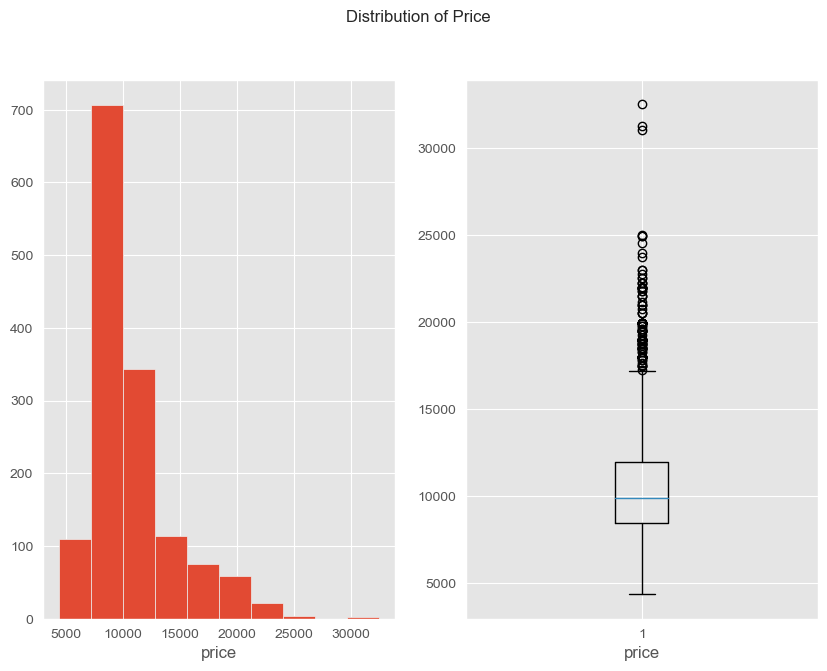

In [19]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
fig.suptitle("Distribution of Price")
ax1.hist(df.price)
ax1.set_xlabel(df.price.name)

ax2.boxplot(df.price)
ax2.set_xlabel(df.price.name)

plt.show()

In [120]:
# Se puede observar que el histograma presenta una forma similar a una distribución normal, pero con un alargamiento hacía la derecha.
# Esta distribución presenta un sesgo positivo (o a la derecha), en donde la media tendrá un valor mayor que la mediana, y la mediana tendrá un valor mayor que la moda.

Mostrar la variable objetivo con mayor zoom

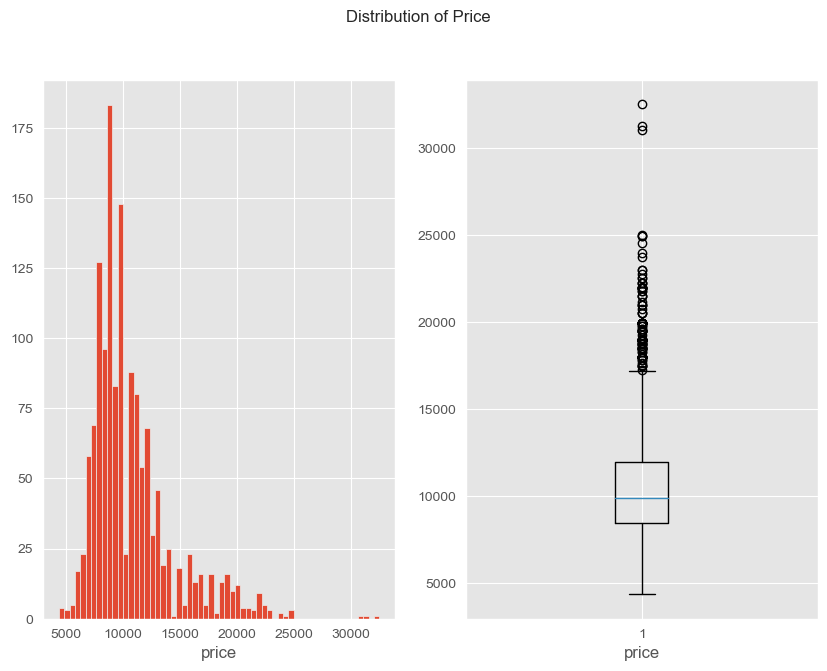

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
fig.suptitle("Distribution of Price")
ax1.hist(df.price, bins=60)
ax1.set_xlabel(df.price.name)

ax2.boxplot(df.price)
ax2.set_xlabel(df.price.name)

plt.show()

#En esta ocasión se configura el parámetro bins en 60, el cual por defecto es 10, y representa el número de contenedores que serán representados en el histograma.

Valor máximo: 17847.5


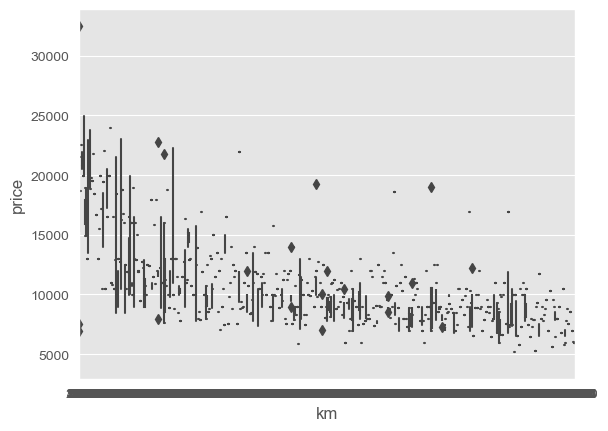

In [21]:
# Ahora buscaremos el valor máximo a partir del cual la variable objetivo (precio) deja de caer dentro del extremo superior
# del diagrama de caja-bigotes (boxplots)

sns.boxplot(x="km", y="price", data=df)
max_value = plt.gca().lines[4].get_ydata().max()
print("Valor máximo:", max_value)

In [22]:
registros_mayores = (df['price'] > max_value).sum()

# Imprimir el número de registros mayores al valor umbral
print("Número de registros mayores a", max_value, ":", registros_mayores)

Número de registros mayores a 17847.5 : 102


In [23]:
#Eliminar valores mayores a 17847.5 para normalizar el precio

df = df[df['price'] <= 17847.5]

Visualizamos como la distribucion de precio se vuelve una distribucion más normal, sin tanto sesgo a la derecha

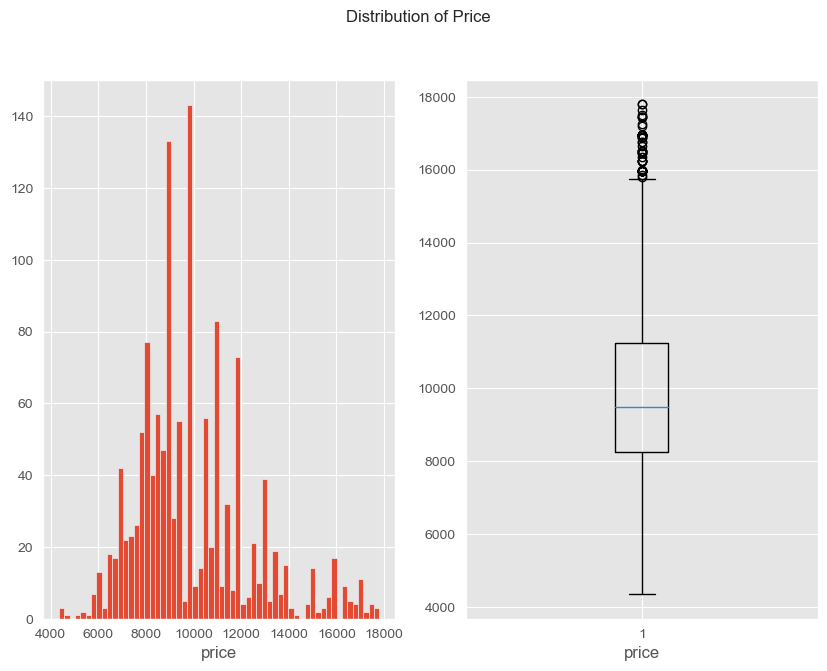

In [24]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
fig.suptitle("Distribution of Price")
ax1.hist(df.price, bins=60)
ax1.set_xlabel(df.price.name)

ax2.boxplot(df.price)
ax2.set_xlabel(df.price.name)

plt.show()

#En esta ocasión se configura el parámetro bins en 60, el cual por defecto es 10, y representa el número de contenedores que serán representados en el histograma.

Variables categoricas

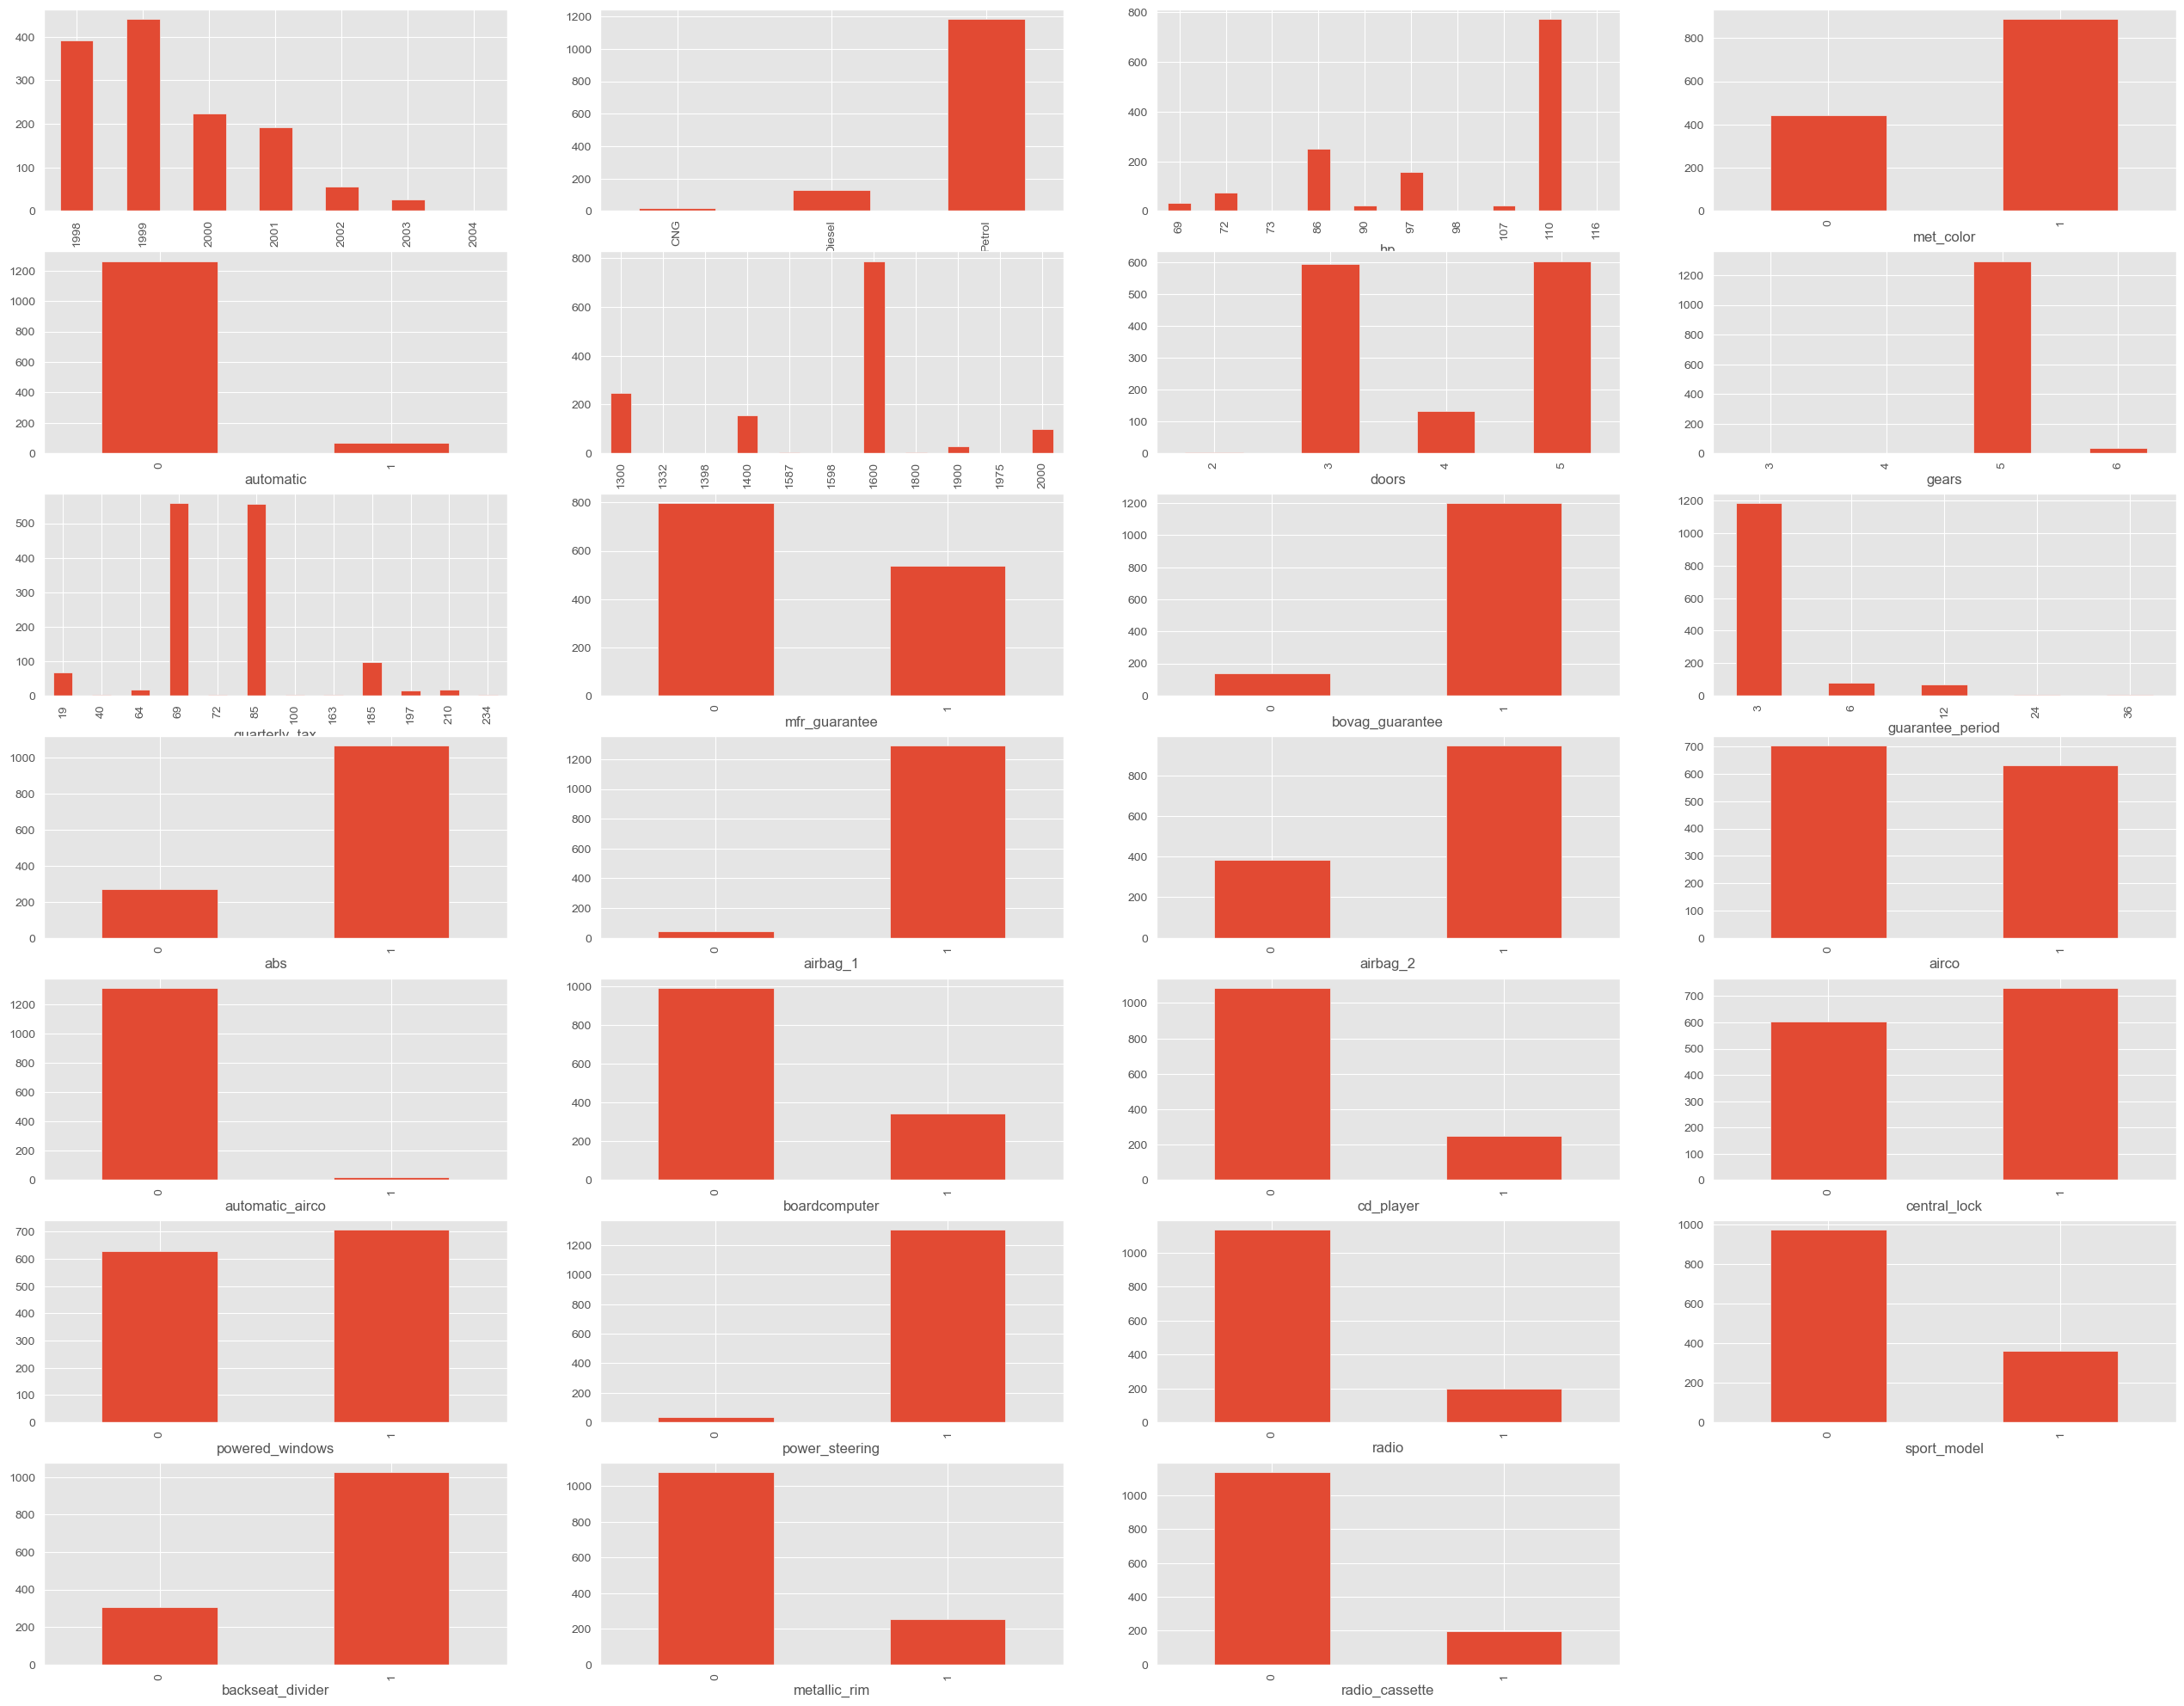

In [25]:
variables_categoricas = ['mfg_year', 'fuel_type', 'hp', 'met_color', 'automatic', 'cc', 'doors', 'gears',
                         'quarterly_tax', 'mfr_guarantee', 'bovag_guarantee', 'guarantee_period', 'abs', 'airbag_1',
                         'airbag_2' , 'airco', 'automatic_airco', 'boardcomputer', 'cd_player', 'central_lock',
                         'powered_windows', 'power_steering', 'radio', 'sport_model', 'backseat_divider',
                         'metallic_rim', 'radio_cassette']

fig = plt.figure(figsize=(32,25))

for i in range(len(variables_categoricas)):
  continuos = variables_categoricas[i]

  ax1 = fig.add_subplot(7,4,i+1)
  ax1.set_xlabel(continuos)

  df.groupby(continuos).size().plot(kind='bar')

In [26]:
# Algunas variables binarias quedan sin ser representadas ya que son demasiadas. (tow_bar y mistlamps)

Variables continuas

In [27]:
variables_continuas = []

fig = plt.figure(figsize=(34,25))

for i in range(len(variables_continuas)):
  continuos = variables_continuas[i]

  ax1 = fig.add_subplot(3,5,i+1)
  ax1.set_xlabel(continuos)

  df[continuos].plot(kind='box')

<Figure size 3400x2500 with 0 Axes>

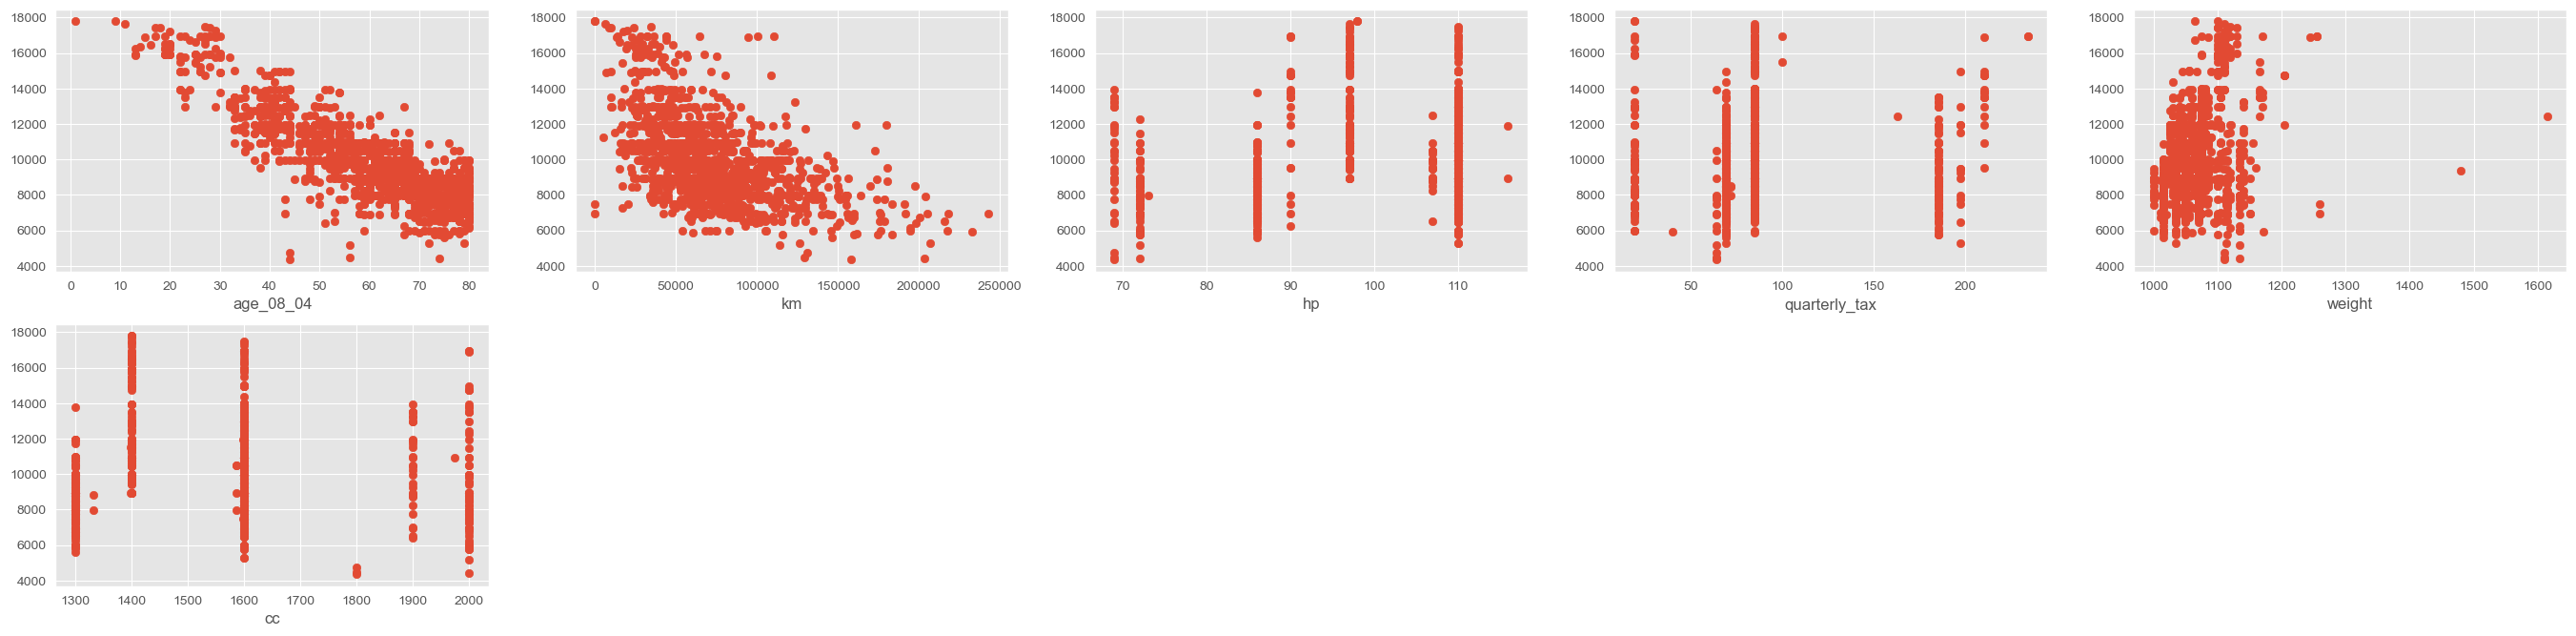

In [28]:
variables_continuas_scatter = ['age_08_04','km','hp','quarterly_tax','weight','cc']

fig = plt.figure(figsize=(34,25))

for i in range(len(variables_continuas_scatter)):
    aux = variables_continuas_scatter[i]

    ax1 = fig.add_subplot(6,5,i+1)
    ax1.set_xlabel(aux)

    plt.scatter(df[aux],df.price)

In [29]:
#Podemos observar como las variables hp, quartely_tax no son continuas, es decir son discretas.
#Sin embargo podemos observar que la variable cc a primera vista parece continua, pero esto se debe a las proporciones del
# del eje x (debido al outliers), en la gráfica anterior se puede observar como cc es un valor discreto y no continuo

In [30]:
#eliminar columnas por falta de significancia estadistica
#columns_to_delete = ['doors', 'gears', 'cc', 'mfr_guarantee', 'met_color', 'automatic', 'guarantee_period']
#df.drop(columns=columns_to_delete, axis=1, inplace=True)

In [31]:
dummies = pd.get_dummies(data=df, columns=['fuel_type'], drop_first=True, prefix="ft_", dtype=int) #convierto la variable categorica Fuel_type en variables booleanas
df = dummies

In [32]:
split_param = {
    'test_size': 0.4,
    'random_state': 42,
    'shuffle': True
}

x_train_1, x_test_1, y_train_1, y_test_1 = train_test_split(df.drop(['price'], axis=1), df.price, **split_param)
x_train_1.shape, x_test_1.shape, y_train_1.shape, y_test_1.shape

((800, 34), (534, 34), (800,), (534,))

Primera ejecución de una regresión con todas las variables.

In [33]:
#Primera ejecución de una regresión con todas las variables.
model = sm.OLS(y_train_1, sm.add_constant(x_train_1)).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.846
Method:                 Least Squares   F-statistic:                     134.5
Date:                Wed, 11 Oct 2023   Prob (F-statistic):          4.60e-293
Time:                        01:21:33   Log-Likelihood:                -6614.4
No. Observations:                 800   AIC:                         1.330e+04
Df Residuals:                     766   BIC:                         1.346e+04
Df Model:                          33                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -0.0065      0.001  

In [34]:
#Linea Base

#Calculamos RMSE (error cuadratico medio)
y_pred_1 = model.predict(sm.add_constant(x_test_1))
RMSE = mean_squared_error(y_test_1,y_pred_1, squared = 'false')
print(f'RMSE: {RMSE}')

RMSE: 970909.9022494564


In [35]:
dw = round(sm.stats.stattools.durbin_watson(model.resid), 3)
kurtosis = model.resid.kurt()
skew = model.resid.skew()
print(dw)
print(kurtosis)
print(skew)

2.02
2.293858860630232
-0.11676808603313421


In [36]:
with mlflow.start_run(run_name="Linea Base"):
  #mlflow.log_metric("accuracy", accuracy)
  mlflow.log_params({"R2": model.rsquared, "R2-Ajustado": model.rsquared_adj, "Skew": skew, "Kurtosis": kurtosis, "Durbin-Watson": dw, "MSE - RMSE": RMSE})
  mlflow.sklearn.log_model(model, "modelo 1")

# Análisis de la regresión y decisión sobre las variables

In [ ]:
# met_color -> t = 0.605 y P>|t| = 0.546
# Falta de significancia estadística: El valor "t" se utiliza para evaluar si el coeficiente es estadísticamente
# diferente de cero. En este caso, un valor "t" de 0.605 sugiere que el coeficiente no es muy diferente de cero.
# Si el valor "t" es cercano a cero, esto indica que la variable independiente correspondiente puede no estar
# contribuyendo significativamente a la predicción del resultado. Esto podría sugerir que la variable no es relevante
# en el modelo y podría eliminarse.

# Alto valor p: El valor "P>|t|" se utiliza para evaluar si el coeficiente es estadísticamente significativo.
# Un valor p alto, como 0.546, sugiere que no hay suficiente evidencia para rechazar la hipótesis nula de que el
# coeficiente es igual a cero. En otras palabras, la variable independiente no tiene un efecto estadísticamente
# significativo en el resultado. Un valor p alto es una indicación de que la variable podría no ser importante en el
# modelo.


# Variable         t value     P>|t| value
# mfg_year          -0.258      0.796
# met_color          0.775      0.439
# automatic          1.305      0.192
# cc                -1.003      0.316
# doors              0.345      0.730
# gears              0.081      0.936 
# airbag_1           0.401      0.689
# airbag_2          -0.282      0.778
# cd_player          1.420      0.15
# central_lock      -0.991      0.322
# power_steering     0.344      0.731
# radio             -1.270      0.204
# mistlamps          0.194      0.846
# metallic_rim       0.540      0.589
# radio_cassette     1.130      0.259



# ft__Diesel         1.383      0.167

# Comienzo nuevo modelo - MODELO 2

In [ ]:
columns_to_delete = ['mfg_year', 'met_color', 'automatic','cc', 'doors', 'gears', 'airbag_1', 'airbag_2', 'cd_player', 'central_lock',
                     'power_steering', 'radio', 'mistlamps', 'metallic_rim', 'radio_cassette'] #'ft__Diesel' ]
df2 = df.drop(columns=columns_to_delete, axis=1)
df2 = pd.DataFrame(df2)

In [ ]:
split_param = {
    'test_size': 0.4,
    'random_state': 42,
    'shuffle': True
}

x_train_2, x_test_2, y_train_2, y_test_2 = train_test_split(df2.drop(['price'], axis=1), df2.price, **split_param)
x_train_2.shape, x_test_2.shape, y_train_2.shape, y_test_2.shape

In [ ]:
#Segunda ejecución de una regresión con todas las variables.
model2 = sm.OLS(y_train_2, sm.add_constant(x_train_2)).fit()
print(model2.summary())

In [ ]:
#Calculamos RMSE (error cuadratico medio)
y_pred_2 = model2.predict(sm.add_constant(x_test_2))
RMSE = mean_squared_error(y_test_2,y_pred_2,squared = 'false')
print(f'RMSE: {RMSE}')

In [ ]:
dw = round(sm.stats.stattools.durbin_watson(model2.resid), 3)
kurtosis = model2.resid.kurt()
skew = model2.resid.skew()
print(dw)
print(kurtosis)
print(skew)

In [ ]:
with mlflow.start_run(run_name="Segunda ejecución"):
  #mlflow.log_metric("accuracy", accuracy)
  mlflow.log_params({"R2": model2.rsquared, "R2-Ajustado": model2.rsquared_adj, "Skew": skew, "Kurtosis": kurtosis, "Durbin-Watson": dw, "MSE - RMSE": RMSE})

  mlflow.sklearn.log_model(model, "modelo 2")

In [ ]:
#Siguiendo esta linea las variables a eliminar son:
# Los t value de 2,XX que a su vez poseian un P value bajo.

# sport_model        
# mfr_guarantee
# backseat_divider
# tow_bar 
# boardcomputer     

# Comienzo nuevo modelo - MODELO 3

In [ ]:
columns_to_delete = ['sport_model', 'mfr_guarantee', 'backseat_divider', 'tow_bar', 'boardcomputer']
df3 = df2.drop(columns=columns_to_delete, axis=1)
df3 = pd.DataFrame(df3)

In [ ]:
split_param = {
    'test_size': 0.4,
    'random_state': 42,
    'shuffle': True
}

x_train_3, x_test_3, y_train_3, y_test_3 = train_test_split(df3.drop(['price'], axis=1), df3.price, **split_param)
x_train_3.shape, x_test_3.shape, y_train_3.shape, y_test_3.shape

In [ ]:
#Tercera ejecución de una regresión con todas las variables.
model3 = sm.OLS(y_train_3, sm.add_constant(x_train_3)).fit()
print(model3.summary())

In [ ]:
#Calculamos RMSE (error cuadratico medio)
y_pred_3 = model3.predict(sm.add_constant(x_test_3))
RMSE = mean_squared_error(y_test_3,y_pred_3, squared = 'false')
print(f'RMSE: {RMSE}')

In [ ]:
dw = round(sm.stats.stattools.durbin_watson(model3.resid), 3)
kurtosis = model3.resid.kurt()
skew = model3.resid.skew()
print(dw)
print(kurtosis)
print(skew)

In [ ]:
with mlflow.start_run(run_name="Tercera Ejecución"):
  #mlflow.log_metric("accuracy", accuracy)
  mlflow.log_params({"R2": model3.rsquared, "R2-Ajustado": model3.rsquared_adj, "Skew": skew, "Kurtosis": kurtosis, "Durbin-Watson": dw, "MSE - RMSE": RMSE})

  mlflow.sklearn.log_model(model, "modelo 3")

In [ ]:
#Siguiendo esta linea las variables a eliminar son:

# hp
# airco

# Comienzo nuevo modelo - MODELO 4

In [ ]:
columns_to_delete = ['hp', 'airco']
df4 = df3.drop(columns=columns_to_delete, axis=1)
df4 = pd.DataFrame(df4)

In [ ]:
split_param = {
    'test_size': 0.4,
    'random_state': 42,
    'shuffle': True
}

x_train_4, x_test_4, y_train_4, y_test_4 = train_test_split(df4.drop(['price'], axis=1), df4.price, **split_param)
x_train_4.shape, x_test_4.shape, y_train_4.shape, y_test_4.shape

In [ ]:
#Cuarta ejecución de una regresión con todas las variables.
model4 = sm.OLS(y_train_4, sm.add_constant(x_train_4)).fit()
print(model4.summary())

In [ ]:
#Calculamos RMSE (error cuadratico medio)
y_pred_4 = model4.predict(sm.add_constant(x_test_4))
RMSE = mean_squared_error(y_test_4,y_pred_4, squared = 'false')
print(f'RMSE: {RMSE}')

In [ ]:
dw = round(sm.stats.stattools.durbin_watson(model4.resid), 3)
kurtosis = model4.resid.kurt()
skew = model4.resid.skew()
print(dw)
print(kurtosis)
print(skew)

In [ ]:
with mlflow.start_run(run_name="Ultima ejecucion"):
  #mlflow.log_metric("accuracy", accuracy)
  mlflow.log_params({"R2": model4.rsquared, "R2-Ajustado": model4.rsquared_adj, "Skew": skew, "Kurtosis": kurtosis, "Durbin-Watson": dw, "MSE - RMSE": RMSE})

  mlflow.sklearn.log_model(model, "modelo 4")


TEST

In [ ]:
testDf = df4

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
fig.suptitle("Distribution of Price")
ax1.hist(testDf.price, bins=60)
ax1.set_xlabel(testDf.price.name)

ax2.boxplot(testDf.price)
ax2.set_xlabel(testDf.price.name)

plt.show()

In [ ]:
sns.boxplot(x="km", y="price", data=testDf)
max_value = plt.gca().lines[4].get_ydata().max()
print("Valor máximo:", max_value)

In [ ]:
# Crear una máscara booleana para los registros que cumplen la condición
condicion = testDf['price'] <= 17847.5

# Filtrar el DataFrame para mantener solo los registros que cumplen la condición
df_filtrado = testDf[condicion]

# Mostrar el DataFrame resultante
df_filtrado.info()

In [ ]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(10, 7))
fig.suptitle("Distribution of Price")
ax1.hist(df_filtrado.price, bins=80)
ax1.set_xlabel(df_filtrado.price.name)

ax2.boxplot(df_filtrado.price)
ax2.set_xlabel(df_filtrado.price.name)

plt.show()

In [ ]:
variables_continuas_scatter = ['age_08_04','km','hp','quarterly_tax','weight']

fig = plt.figure(figsize=(34,25))

for i in range(len(variables_continuas_scatter)):
    aux = variables_continuas_scatter[i]

    ax1 = fig.add_subplot(6,5,i+1)
    ax1.set_xlabel(aux)

    plt.scatter(df_filtrado[aux],df_filtrado.price)

# 5to Modelo

In [ ]:
split_param = {
    'test_size': 0.4,
    'random_state': 42,
    'shuffle': True
}

x_train_5, x_test_5, y_train_5, y_test_5 = train_test_split(df_filtrado.drop(['price'], axis=1), df_filtrado.price, **split_param)
x_train_5.shape, x_test_5.shape, y_train_5.shape, y_test_5.shape

In [ ]:
#Cuarta ejecución de una regresión con todas las variables.
model5 = sm.OLS(y_train_5, sm.add_constant(x_train_5)).fit()
print(model5.summary())

In [ ]:
#Calculamos RMSE (error cuadratico medio)
y_pred_5 = model5.predict(sm.add_constant(x_test_5))
RMSE = mean_squared_error(y_test_5,y_pred_5, squared = 'false')
print(f'RMSE: {RMSE}')

In [ ]:
dw = print(round(sm.stats.stattools.durbin_watson(model5.resid),3))

In [ ]:
with mlflow.start_run():
  #mlflow.log_metric("accuracy", accuracy)
  mlflow.log_params({"R2": model5.rsquared, "R2-Ajustado": model5.rsquared_adj, "Skew": model5.resid.skew, "Kurtosis": model5.resid.kurtosis, "Durbin-Watson": dw, "MSE - RMSE": RMSE})

  mlflow.sklearn.log_model(model, "modelo 5")

In [ ]:
plt.figure(figsize=(12,12))
plt.title("Mapa de Correlaciones")
corr = df_filtrado.corr(method="pearson")
sns.heatmap(corr, annot=True, cmap=plt.cm.viridis, linewidths=0.1, linecolor="white", square=True)